# PreTrain

In [1]:
from model.sswae_dev2 import SSWAE_HSIC_MNIST as cur_model

import os, sys, configparser, logging, argparse, time
sys.path.append('/'.join(os.getcwd().split('/')[:-2]))

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

from XAE.dataset import rmMNIST
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid
from random import sample

import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
y_dim = 4

d = 64
embed_data = nn.Sequential(
    nn.Conv2d(1, d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(d),
    nn.ReLU(True),

    nn.Conv2d(d, 2*d, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Conv2d(2*d, 2*d, kernel_size = 4, padding = 'same', bias = False),
    nn.BatchNorm2d(2*d),
    nn.ReLU(True),

    nn.Flatten(),
).to(device)

embed_condition = nn.Sequential(
    nn.Linear(49*2*d, d),
    nn.BatchNorm1d(d),
    nn.ReLU(True),
    
    nn.Linear(d, y_dim),
).to(device)

enc_activation = nn.Sequential(
    nn.BatchNorm1d(y_dim),
    nn.ReLU(True),
    nn.Linear(y_dim, 10),
).to(device)

init_params(embed_data)
init_params(embed_condition)
init_params(enc_activation)

In [3]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [4]:
def kk(x, y, diag = True):
    stat = 0.
    for scale in [.1, .2, .5, 1., 2., 5., 10.]:
        C = scale*2*y_dim*2
        kernel = (C/(C + (x.unsqueeze(0) - y.unsqueeze(1)).pow(2).sum(dim = 2)))
        if diag:
            stat += kernel.sum()
        else:
            stat += kernel.sum() - kernel.diag().sum()
    return stat

In [5]:
epoch = 25
opt = optim.Adam(list(embed_data.parameters()) + list(embed_condition.parameters()) + list(enc_activation.parameters()), lr = 1e-3, betas = (0.9, 0.999))
crit = nn.CrossEntropyLoss()
running_loss = 0.0

for k in range(epoch):
    for i, (data, condition) in enumerate(train_generator):
        opt.zero_grad()
        n = len(data)
        x = data.to(device)
        y = condition.to(device)
        
        xx = embed_condition(embed_data(x))
        output = enc_activation(xx)
        loss = crit(output, y)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        
    print('[%d] loss: %.3f' % (k + 1, running_loss / len(train_generator)))
    running_loss = 0.0

[1] loss: 1.757
[2] loss: 0.786
[3] loss: 0.527
[4] loss: 0.444
[5] loss: 0.383
[6] loss: 0.162
[7] loss: 0.063
[8] loss: 0.031
[9] loss: 0.022
[10] loss: 0.015
[11] loss: 0.011
[12] loss: 0.011
[13] loss: 0.010
[14] loss: 0.007
[15] loss: 0.010
[16] loss: 0.007
[17] loss: 0.005
[18] loss: 0.005
[19] loss: 0.008
[20] loss: 0.004
[21] loss: 0.005
[22] loss: 0.007
[23] loss: 0.004
[24] loss: 0.002
[25] loss: 0.003


In [6]:
batch_size = 100
test_data = MNIST('./data/MNIST', train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

a, b = next(iter(test_generator))
embed_condition(embed_data(a.to(device))).shape

torch.Size([100, 4])

In [7]:
f1 = np.zeros((0, 10))
f2 = np.zeros((0, y_dim))

i = 0
for a, b in test_generator:
    f1x = b.to('cpu').detach().numpy()
    f2x = embed_condition(embed_data(a.to(device))).to('cpu').detach().numpy()
    f1 = np.concatenate((f1, f1x), axis = 0)
    f2 = np.concatenate((f2, f2x), axis = 0)
    i += 1
    if i == 5:
        break
        
digit = np.arange(10)
lab = [digit[l.astype(np.bool_)] for l in f1]
lab = np.concatenate(lab)

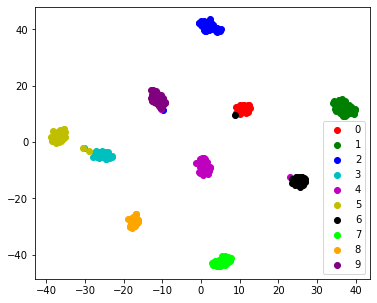

In [8]:
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(f2)

target_ids = list(range(10))

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[lab == i, 0], X_2d[lab == i, 1], c=c, label=str(i))
plt.legend()
plt.show()

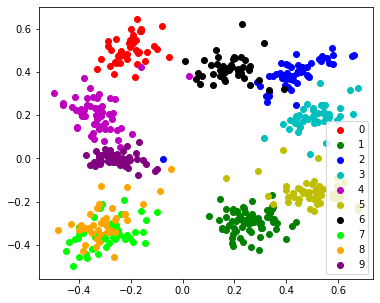

In [9]:
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'lime', 'orange', 'purple'
for i, c in zip(target_ids, colors):
    plt.scatter(f2[lab == i, 0], f2[lab == i, 2], c=c, label=str(i))
plt.legend()
plt.show()

In [10]:
labeled_class = [0,1,2,3,4,5,6,7,8,9]
train_data = rmMNIST('./data/MNIST', train = True, label = True, aux = [labeled_class, []], portion = 1.0, class_no = True)
train_generator = torch.utils.data.DataLoader(train_data, 100, num_workers = 5, shuffle = True, pin_memory=True, drop_last=True)

In [11]:
ys = np.zeros((10, y_dim))
cs = np.zeros(10)

for data, condition in train_generator:
    n = len(data)
    x = data.to(device)
    y = condition.to(device)
    z = embed_condition(embed_data(x))
    
    labs, idxs, counts = y.unique(dim = 0, return_inverse = True, return_counts = True)
    idxs = labs[idxs].view(n,1).expand(-1, y_dim)
    cc = torch.zeros((10, y_dim), dtype = torch.float).to(device).scatter_add_(0, idxs, z)
    ys += cc.detach().to('cpu').numpy()
    cs += counts[labs].detach().to('cpu').numpy()

In [12]:
w = torch.Tensor(ys.transpose()/cs)
w

tensor([[-0.1746,  0.2619,  0.4362,  0.5235, -0.3297,  0.5101,  0.1844, -0.2889,
         -0.2612, -0.2675],
        [-0.0973, -0.1883, -0.1152, -0.0322, -0.1647,  0.4447,  0.4777, -0.2115,
          0.4622,  0.2481],
        [ 0.4678, -0.3012,  0.3752,  0.1740,  0.2141, -0.1696,  0.3881, -0.3336,
         -0.3061,  0.0054],
        [ 0.5546, -0.1477, -0.0951,  0.5528, -0.2211,  0.2554, -0.0056,  0.5172,
         -0.2088,  0.3428]])

In [13]:
f1 = nn.Linear(10, y_dim, bias = False)
f1.weight.data = w
torch.save(f1.state_dict(), f'./result/f1_{y_dim}.pt')

# Train

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/sswae_dev2_1.cfg')

['./config/sswae_dev2_1.cfg']

In [5]:
mm = cur_model(cfg, log, device = device)
mm.f1.load_state_dict(torch.load(f'./result/f1_{y_dim}.pt'))
mm.train()
# mm.load('./%s' % (cfg['path_info']['save_path']))

[default |INFO|_base_model.py:27] ------------------------------------------------------------
[default |INFO|_base_model.py:29] model_name : SSWAE_HSIC_MNIST
[default |INFO|_base_model.py:29] train_data : rmMNIST
[default |INFO|_base_model.py:29] train_data_label : True
[default |INFO|_base_model.py:29] z_sampler : gaus
[default |INFO|_base_model.py:29] z_dim : 6
[default |INFO|_base_model.py:29] y_sampler : gaus
[default |INFO|_base_model.py:29] y_dim : 4
[default |INFO|_base_model.py:29] labeled_class : 0,1,2,3,4,5,6,7,8,9
[default |INFO|_base_model.py:29] unlabeled_class : 
[default |INFO|_base_model.py:29] test_class : 
[default |INFO|_base_model.py:29] portion : 1.0
[default |INFO|_base_model.py:29] encoder_pretrain : False
[default |INFO|_base_model.py:29] encoder_pretrain_step : 3
[default |INFO|_base_model.py:29] lr : 5e-4
[default |INFO|_base_model.py:29] beta1 : 0.5
[default |INFO|_base_model.py:29] lr_adv : 2e-4
[default |INFO|_base_model.py:29] beta1_adv : 0.5
[default |IN

[default |INFO|model.py:1280] [01/80]  loss: 2.341961e-01  D: 6.910611e-01  D2: 2.345026e-02  D3: 3.699747e-03
test loss: 1.765221e-01  D: 7.145073e-01  D2: 6.277847e-03  D3: 5.003460e-03


[default |INFO|model.py:1280] [02/80]  loss: 1.620548e-01  D: 6.930774e-01  D2: 1.577179e-03  D3: 5.962535e-03
test loss: 1.476387e-01  D: 6.736143e-01  D2: -3.824997e-03  D3: 5.215437e-03


[default |INFO|model.py:1280] [03/80]  loss: 1.452927e-01  D: 7.005303e-01  D2: -4.165483e-03  D3: 6.944535e-03
test loss: 1.484845e-01  D: 6.806261e-01  D2: -3.965530e-03  D3: 6.274190e-03


[default |INFO|model.py:1280] [04/80]  loss: 1.245527e-01  D: 6.928222e-01  D2: -4.395380e-03  D3: 8.053323e-03
test loss: 1.124050e-01  D: 6.937713e-01  D2: -5.059061e-03  D3: 9.262721e-03


[default |INFO|model.py:1280] [05/80]  loss: 1.166336e-01  D: 7.003132e-01  D2: -4.287044e-03  D3: 9.927081e-03
test loss: 9.809971e-02  D: 6.789985e-01  D2: -3.877163e-03  D3: 9.217381e-03


[default |INFO|model.py:1280] [06/80]  loss: 9.536500e-02  D: 6.940611e-01  D2: -4.900964e-03  D3: 9.653852e-03
test loss: 1.071231e-01  D: 6.644721e-01  D2: -4.479103e-03  D3: 1.120383e-02


[default |INFO|model.py:1280] [07/80]  loss: 9.577234e-02  D: 6.967360e-01  D2: -4.824904e-03  D3: 1.122587e-02
test loss: 1.077419e-01  D: 7.160462e-01  D2: -5.212326e-03  D3: 1.499285e-02


[default |INFO|model.py:1280] [08/80]  loss: 9.450709e-02  D: 6.926714e-01  D2: -4.383241e-03  D3: 1.456559e-02
test loss: 8.491368e-02  D: 6.959983e-01  D2: -4.513741e-03  D3: 1.303402e-02


[default |INFO|model.py:1280] [09/80]  loss: 8.752107e-02  D: 6.933117e-01  D2: -5.093546e-03  D3: 1.462050e-02
test loss: 8.205037e-02  D: 6.946908e-01  D2: -5.196543e-03  D3: 1.468313e-02


[default |INFO|model.py:1280] [10/80]  loss: 8.555737e-02  D: 6.934313e-01  D2: -5.227121e-03  D3: 1.356522e-02
test loss: 8.184233e-02  D: 6.812250e-01  D2: -5.534878e-03  D3: 1.276326e-02


[default |INFO|model.py:1280] [11/80]  loss: 8.363770e-02  D: 6.946409e-01  D2: -5.462941e-03  D3: 1.156099e-02
test loss: 8.600143e-02  D: 6.790238e-01  D2: -5.548477e-03  D3: 1.060220e-02


[default |INFO|model.py:1280] [12/80]  loss: 8.468063e-02  D: 6.930339e-01  D2: -5.175653e-03  D3: 1.328374e-02
test loss: 8.456007e-02  D: 6.837996e-01  D2: -5.248919e-03  D3: 1.381662e-02


[default |INFO|model.py:1280] [13/80]  loss: 8.109506e-02  D: 6.949925e-01  D2: -5.472644e-03  D3: 1.263538e-02
test loss: 7.852573e-02  D: 6.965162e-01  D2: -5.396776e-03  D3: 1.278569e-02


[default |INFO|model.py:1280] [14/80]  loss: 7.937948e-02  D: 6.931096e-01  D2: -5.748498e-03  D3: 1.300277e-02
test loss: 7.637981e-02  D: 6.802939e-01  D2: -5.800858e-03  D3: 1.220417e-02


[default |INFO|model.py:1280] [15/80]  loss: 7.587948e-02  D: 6.945902e-01  D2: -5.663190e-03  D3: 1.310446e-02
test loss: 7.880432e-02  D: 7.213888e-01  D2: -5.016718e-03  D3: 1.665879e-02


[default |INFO|model.py:1280] [16/80]  loss: 7.390367e-02  D: 6.936667e-01  D2: -5.956197e-03  D3: 1.322596e-02
test loss: 7.178752e-02  D: 6.877737e-01  D2: -6.158018e-03  D3: 1.217444e-02


[default |INFO|model.py:1280] [17/80]  loss: 7.180781e-02  D: 6.936698e-01  D2: -5.974738e-03  D3: 1.334956e-02
test loss: 6.720788e-02  D: 7.007677e-01  D2: -7.135925e-03  D3: 1.196441e-02


[default |INFO|model.py:1280] [18/80]  loss: 7.101927e-02  D: 6.937697e-01  D2: -6.300899e-03  D3: 1.272071e-02
test loss: 7.267794e-02  D: 6.933731e-01  D2: -6.320601e-03  D3: 1.254223e-02


[default |INFO|model.py:1280] [19/80]  loss: 6.908227e-02  D: 6.931350e-01  D2: -6.373143e-03  D3: 1.316657e-02
test loss: 6.793336e-02  D: 6.785583e-01  D2: -6.919832e-03  D3: 1.304634e-02


[default |INFO|model.py:1280] [20/80]  loss: 6.888609e-02  D: 6.934306e-01  D2: -6.478308e-03  D3: 1.286763e-02
test loss: 6.749631e-02  D: 7.153613e-01  D2: -6.618586e-03  D3: 1.297700e-02


[default |INFO|model.py:1280] [21/80]  loss: 6.698698e-02  D: 6.943629e-01  D2: -6.718669e-03  D3: 1.303602e-02
test loss: 6.563405e-02  D: 7.126280e-01  D2: -6.507082e-03  D3: 1.319844e-02


[default |INFO|model.py:1280] [22/80]  loss: 6.606992e-02  D: 6.939095e-01  D2: -6.814814e-03  D3: 1.302798e-02
test loss: 6.568992e-02  D: 6.865983e-01  D2: -6.886415e-03  D3: 1.250849e-02


[default |INFO|model.py:1280] [23/80]  loss: 6.418808e-02  D: 6.935104e-01  D2: -6.946400e-03  D3: 1.313522e-02
test loss: 6.308234e-02  D: 7.013232e-01  D2: -7.513847e-03  D3: 1.302452e-02


[default |INFO|model.py:1280] [24/80]  loss: 6.349870e-02  D: 6.940810e-01  D2: -7.223852e-03  D3: 1.310530e-02
test loss: 6.426952e-02  D: 6.976032e-01  D2: -7.529869e-03  D3: 1.265052e-02


[default |INFO|model.py:1280] [25/80]  loss: 6.259997e-02  D: 6.932675e-01  D2: -7.242007e-03  D3: 1.322169e-02
test loss: 6.435417e-02  D: 7.000377e-01  D2: -7.390852e-03  D3: 1.393303e-02


[default |INFO|model.py:1280] [26/80]  loss: 6.179807e-02  D: 6.942351e-01  D2: -7.521648e-03  D3: 1.300632e-02
test loss: 6.044024e-02  D: 6.993983e-01  D2: -7.498674e-03  D3: 1.260271e-02


[default |INFO|model.py:1280] [27/80]  loss: 6.108814e-02  D: 6.931922e-01  D2: -7.541142e-03  D3: 1.314824e-02
test loss: 6.148197e-02  D: 6.939354e-01  D2: -7.343969e-03  D3: 1.424215e-02


[default |INFO|model.py:1280] [28/80]  loss: 6.121459e-02  D: 6.937045e-01  D2: -7.605672e-03  D3: 1.288684e-02
test loss: 6.387066e-02  D: 6.994597e-01  D2: -6.822147e-03  D3: 1.439589e-02


[default |INFO|model.py:1280] [29/80]  loss: 6.032255e-02  D: 6.941609e-01  D2: -7.911326e-03  D3: 1.305697e-02
test loss: 6.208351e-02  D: 6.933381e-01  D2: -7.344303e-03  D3: 1.376372e-02


[default |INFO|model.py:1280] [30/80]  loss: 5.982091e-02  D: 6.934342e-01  D2: -7.912165e-03  D3: 1.299060e-02
test loss: 6.143613e-02  D: 6.909659e-01  D2: -8.125286e-03  D3: 1.245944e-02


[default |INFO|model.py:1280] [31/80]  loss: 6.100553e-02  D: 6.936566e-01  D2: -7.969774e-03  D3: 1.242342e-02
test loss: 6.107601e-02  D: 6.839410e-01  D2: -8.249512e-03  D3: 1.316909e-02


[default |INFO|model.py:1280] [32/80]  loss: 5.922678e-02  D: 6.940150e-01  D2: -8.008181e-03  D3: 1.278851e-02
test loss: 6.235464e-02  D: 6.910566e-01  D2: -7.372847e-03  D3: 1.149430e-02


[default |INFO|model.py:1280] [33/80]  loss: 5.848674e-02  D: 6.932485e-01  D2: -8.198188e-03  D3: 1.272196e-02
test loss: 6.425948e-02  D: 6.925316e-01  D2: -7.987404e-03  D3: 1.298827e-02


[default |INFO|model.py:1280] [34/80]  loss: 5.906314e-02  D: 6.942587e-01  D2: -8.311235e-03  D3: 1.241561e-02
test loss: 5.951056e-02  D: 6.885547e-01  D2: -8.339405e-03  D3: 1.124916e-02


[default |INFO|model.py:1280] [35/80]  loss: 5.851735e-02  D: 6.933631e-01  D2: -8.305235e-03  D3: 1.259471e-02
test loss: 5.990135e-02  D: 6.949003e-01  D2: -8.483171e-03  D3: 1.279233e-02


[default |INFO|model.py:1280] [36/80]  loss: 5.802687e-02  D: 6.931147e-01  D2: -8.491901e-03  D3: 1.242910e-02
test loss: 5.959161e-02  D: 6.943540e-01  D2: -8.286009e-03  D3: 1.235334e-02


[default |INFO|model.py:1280] [37/80]  loss: 5.807496e-02  D: 6.933708e-01  D2: -8.499602e-03  D3: 1.235704e-02
test loss: 5.730337e-02  D: 6.985050e-01  D2: -8.802576e-03  D3: 1.290260e-02


[default |INFO|model.py:1280] [38/80]  loss: 5.802744e-02  D: 6.933152e-01  D2: -8.568083e-03  D3: 1.245784e-02
test loss: 6.041954e-02  D: 6.999059e-01  D2: -8.782682e-03  D3: 1.142801e-02


[default |INFO|model.py:1280] [39/80]  loss: 5.784621e-02  D: 6.937513e-01  D2: -8.571151e-03  D3: 1.240098e-02
test loss: 5.930572e-02  D: 6.956202e-01  D2: -8.844051e-03  D3: 1.160094e-02


[default |INFO|model.py:1280] [40/80]  loss: 5.653616e-02  D: 6.931867e-01  D2: -8.662868e-03  D3: 1.259223e-02
test loss: 5.836172e-02  D: 6.919917e-01  D2: -8.697777e-03  D3: 1.246276e-02


[default |INFO|model.py:1280] [41/80]  loss: 5.650044e-02  D: 6.935347e-01  D2: -8.817164e-03  D3: 1.240555e-02
test loss: 5.732187e-02  D: 6.876266e-01  D2: -8.932543e-03  D3: 1.230702e-02


[default |INFO|model.py:1280] [42/80]  loss: 5.620938e-02  D: 6.933315e-01  D2: -8.803191e-03  D3: 1.228252e-02
test loss: 5.710741e-02  D: 7.101360e-01  D2: -8.828516e-03  D3: 1.149980e-02


[default |INFO|model.py:1280] [43/80]  loss: 5.620758e-02  D: 6.935499e-01  D2: -8.894958e-03  D3: 1.233852e-02
test loss: 5.885711e-02  D: 7.008388e-01  D2: -9.006433e-03  D3: 1.248210e-02


[default |INFO|model.py:1280] [44/80]  loss: 5.596310e-02  D: 6.937932e-01  D2: -8.905691e-03  D3: 1.231409e-02
test loss: 5.824418e-02  D: 6.979644e-01  D2: -9.063101e-03  D3: 1.216956e-02


[default |INFO|model.py:1280] [45/80]  loss: 5.526438e-02  D: 6.928240e-01  D2: -8.943604e-03  D3: 1.241605e-02
test loss: 5.846934e-02  D: 6.946077e-01  D2: -9.005089e-03  D3: 1.201391e-02


[default |INFO|model.py:1280] [46/80]  loss: 5.527597e-02  D: 6.935480e-01  D2: -9.008522e-03  D3: 1.218312e-02
test loss: 5.839942e-02  D: 6.922114e-01  D2: -9.159737e-03  D3: 1.214822e-02


[default |INFO|model.py:1280] [47/80]  loss: 5.546333e-02  D: 6.931222e-01  D2: -9.046432e-03  D3: 1.218105e-02
test loss: 5.651925e-02  D: 6.805772e-01  D2: -9.185810e-03  D3: 1.220620e-02


[default |INFO|model.py:1280] [48/80]  loss: 5.496470e-02  D: 6.930567e-01  D2: -9.049007e-03  D3: 1.207079e-02
test loss: 5.648375e-02  D: 6.950446e-01  D2: -9.239140e-03  D3: 1.288471e-02


[default |INFO|model.py:1280] [49/80]  loss: 5.441290e-02  D: 6.932174e-01  D2: -9.119194e-03  D3: 1.214478e-02
test loss: 5.692159e-02  D: 7.052670e-01  D2: -8.260098e-03  D3: 1.149134e-02


[default |INFO|model.py:1280] [50/80]  loss: 5.451907e-02  D: 6.933663e-01  D2: -9.134272e-03  D3: 1.212417e-02
test loss: 5.783511e-02  D: 6.827220e-01  D2: -9.004021e-03  D3: 1.283724e-02


[default |INFO|model.py:1280] [51/80]  loss: 5.478032e-02  D: 6.926202e-01  D2: -9.166824e-03  D3: 1.201603e-02
test loss: 5.713229e-02  D: 6.997638e-01  D2: -9.209499e-03  D3: 1.180333e-02


[default |INFO|model.py:1280] [52/80]  loss: 5.573977e-02  D: 6.946023e-01  D2: -9.278569e-03  D3: 1.182888e-02
test loss: 5.799256e-02  D: 6.943948e-01  D2: -9.371290e-03  D3: 1.111447e-02


[default |INFO|model.py:1280] [53/80]  loss: 5.511295e-02  D: 6.931926e-01  D2: -9.224332e-03  D3: 1.181692e-02
test loss: 5.694197e-02  D: 6.977461e-01  D2: -9.299459e-03  D3: 1.256088e-02


[default |INFO|model.py:1280] [54/80]  loss: 5.419633e-02  D: 6.932725e-01  D2: -9.298506e-03  D3: 1.211001e-02
test loss: 5.584339e-02  D: 6.989530e-01  D2: -9.354925e-03  D3: 1.169334e-02


[default |INFO|model.py:1280] [55/80]  loss: 5.349926e-02  D: 6.932267e-01  D2: -9.334704e-03  D3: 1.214689e-02
test loss: 5.546462e-02  D: 6.954741e-01  D2: -9.378881e-03  D3: 1.203766e-02


[default |INFO|model.py:1280] [56/80]  loss: 5.334176e-02  D: 6.932875e-01  D2: -9.334237e-03  D3: 1.204032e-02
test loss: 5.642579e-02  D: 6.964425e-01  D2: -9.196911e-03  D3: 1.120844e-02


[default |INFO|model.py:1280] [57/80]  loss: 5.354643e-02  D: 6.932685e-01  D2: -9.392195e-03  D3: 1.204278e-02
test loss: 5.639916e-02  D: 6.935048e-01  D2: -9.430056e-03  D3: 1.259223e-02


[default |INFO|model.py:1280] [58/80]  loss: 5.365009e-02  D: 6.934644e-01  D2: -9.319391e-03  D3: 1.215064e-02
test loss: 5.561927e-02  D: 6.927462e-01  D2: -9.399405e-03  D3: 1.150201e-02


[default |INFO|model.py:1280] [59/80]  loss: 5.332426e-02  D: 6.931932e-01  D2: -9.427328e-03  D3: 1.182161e-02
test loss: 5.578541e-02  D: 6.925993e-01  D2: -9.454460e-03  D3: 1.156150e-02


[default |INFO|model.py:1280] [60/80]  loss: 5.396664e-02  D: 6.926904e-01  D2: -9.457753e-03  D3: 1.182639e-02
test loss: 5.669671e-02  D: 6.898608e-01  D2: -9.616385e-03  D3: 1.163867e-02


[default |INFO|model.py:1280] [61/80]  loss: 5.368920e-02  D: 6.932670e-01  D2: -9.432631e-03  D3: 1.173657e-02
test loss: 5.578081e-02  D: 6.909599e-01  D2: -9.306602e-03  D3: 1.064914e-02


[default |INFO|model.py:1280] [62/80]  loss: 5.336539e-02  D: 6.935272e-01  D2: -9.459645e-03  D3: 1.182268e-02
test loss: 5.616599e-02  D: 7.067163e-01  D2: -9.241848e-03  D3: 1.153023e-02


[default |INFO|model.py:1280] [63/80]  loss: 5.309066e-02  D: 6.926059e-01  D2: -9.463336e-03  D3: 1.179769e-02
test loss: 5.457742e-02  D: 6.831295e-01  D2: -9.573765e-03  D3: 1.190493e-02


[default |INFO|model.py:1280] [64/80]  loss: 5.274802e-02  D: 6.929843e-01  D2: -9.535267e-03  D3: 1.187948e-02
test loss: 5.617963e-02  D: 6.944523e-01  D2: -9.357948e-03  D3: 1.192985e-02


[default |INFO|model.py:1280] [65/80]  loss: 5.253055e-02  D: 6.929278e-01  D2: -9.564676e-03  D3: 1.165769e-02
test loss: 5.536247e-02  D: 6.857139e-01  D2: -9.552050e-03  D3: 1.291063e-02


[default |INFO|model.py:1280] [66/80]  loss: 5.198161e-02  D: 6.927832e-01  D2: -9.546405e-03  D3: 1.188128e-02
test loss: 5.552366e-02  D: 6.942785e-01  D2: -9.637280e-03  D3: 1.148910e-02


[default |INFO|model.py:1280] [67/80]  loss: 5.216411e-02  D: 6.930372e-01  D2: -9.522691e-03  D3: 1.192251e-02
test loss: 5.416329e-02  D: 6.921814e-01  D2: -9.521790e-03  D3: 1.101857e-02


[default |INFO|model.py:1280] [68/80]  loss: 5.201170e-02  D: 6.933620e-01  D2: -9.594385e-03  D3: 1.175059e-02
test loss: 5.440451e-02  D: 6.954929e-01  D2: -9.349670e-03  D3: 1.197316e-02


[default |INFO|model.py:1280] [69/80]  loss: 5.274490e-02  D: 6.940165e-01  D2: -9.600048e-03  D3: 1.156232e-02
test loss: 5.642833e-02  D: 7.003915e-01  D2: -9.603109e-03  D3: 1.116546e-02


[default |INFO|model.py:1280] [70/80]  loss: 5.171902e-02  D: 6.929064e-01  D2: -9.596581e-03  D3: 1.176473e-02
test loss: 5.494566e-02  D: 6.997115e-01  D2: -9.687777e-03  D3: 1.100137e-02


[default |INFO|model.py:1280] [71/80]  loss: 5.146695e-02  D: 6.931564e-01  D2: -9.626735e-03  D3: 1.181369e-02
test loss: 5.461154e-02  D: 6.857229e-01  D2: -9.606333e-03  D3: 1.182527e-02


[default |INFO|model.py:1280] [72/80]  loss: 5.157990e-02  D: 6.934236e-01  D2: -9.627347e-03  D3: 1.181554e-02
test loss: 5.356449e-02  D: 6.910788e-01  D2: -9.710274e-03  D3: 1.100283e-02


[default |INFO|model.py:1280] [73/80]  loss: 5.125816e-02  D: 6.932815e-01  D2: -9.625624e-03  D3: 1.174994e-02
test loss: 5.463792e-02  D: 6.930862e-01  D2: -9.661198e-03  D3: 1.174809e-02


[default |INFO|model.py:1280] [74/80]  loss: 5.143416e-02  D: 6.932878e-01  D2: -9.632629e-03  D3: 1.174057e-02
test loss: 5.473490e-02  D: 6.907356e-01  D2: -9.617758e-03  D3: 1.150375e-02


[default |INFO|model.py:1280] [75/80]  loss: 5.144205e-02  D: 6.930161e-01  D2: -9.650029e-03  D3: 1.174263e-02
test loss: 5.368894e-02  D: 6.951962e-01  D2: -9.596519e-03  D3: 1.176934e-02


[default |INFO|model.py:1280] [76/80]  loss: 5.136473e-02  D: 6.936692e-01  D2: -9.653792e-03  D3: 1.172347e-02
test loss: 5.555409e-02  D: 6.962849e-01  D2: -9.828176e-03  D3: 1.171842e-02


[default |INFO|model.py:1280] [77/80]  loss: 5.159925e-02  D: 6.928635e-01  D2: -9.665235e-03  D3: 1.152820e-02
test loss: 5.375290e-02  D: 6.897306e-01  D2: -9.642725e-03  D3: 1.136537e-02


[default |INFO|model.py:1280] [78/80]  loss: 5.074561e-02  D: 6.933992e-01  D2: -9.687845e-03  D3: 1.162677e-02
test loss: 5.432358e-02  D: 6.946451e-01  D2: -9.622564e-03  D3: 1.213997e-02


[default |INFO|model.py:1280] [79/80]  loss: 5.101716e-02  D: 6.934086e-01  D2: -9.695452e-03  D3: 1.165222e-02
test loss: 5.447121e-02  D: 6.917114e-01  D2: -9.706497e-03  D3: 1.102316e-02


[default |INFO|model.py:1280] [80/80]  loss: 5.072456e-02  D: 6.932918e-01  D2: -9.696120e-03  D3: 1.161142e-02
test loss: 5.294325e-02  D: 6.866281e-01  D2: -9.763298e-03  D3: 1.087315e-02
[default |INFO|model.py:1351] Training Finished!
[default |INFO|model.py:1352] Elapsed time: 3104.132s


# Test

In [6]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [7]:
test_iter = iter(test_generator)
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()


In [8]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[1])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()

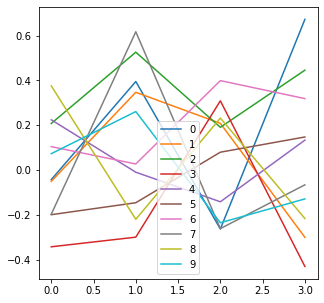

In [9]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

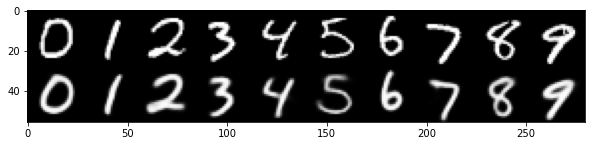

In [10]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [13]:
exn = 5

In [14]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

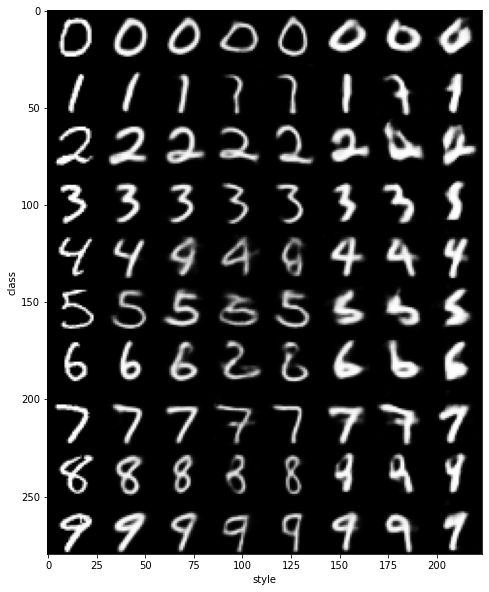

In [15]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [16]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

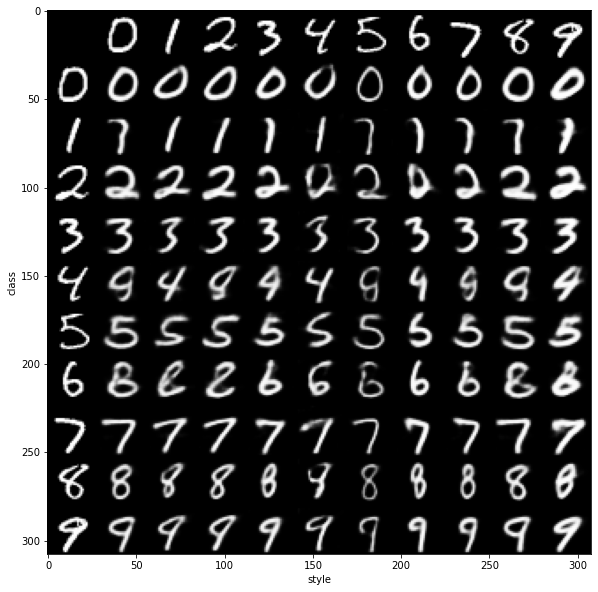

In [17]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()